<a href="https://colab.research.google.com/github/yenlung/Python-AI-Book/blob/main/%E5%86%92%E9%9A%AA%E5%89%AF%E6%9C%AC03_%E6%96%87%E5%AD%97%E7%94%9F%E5%9C%96%E6%A8%A1%E5%9E%8B%E7%9A%84%E9%80%B2%E9%9A%8E%E6%8A%80%E5%B7%A7.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%matplotlib inline

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

上次的冒險中, 我們介紹用不同版本的 Stable Diffusion 生圖的方法。試玩一陣之後, 你可能發現, 尤其在生照片的時候, 真的是很吃運氣, 常常生不出令人滿意的結果。現在我們來介紹幾個進階技巧, 讓大家更能調整輸出後的結果。

### 1. 安裝必要套件

In [ ]:
!pip install transformers
!pip install diffusers["torch"]
!pip install sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 14.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 107.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 24.5 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 716.4/716.4 KB 12.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 26.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 16.4 MB/s eta 0:00:00


### 2. 設好我們的 pipeline

如果深入 Stable Diffusion, 還有一個叫做 samplers 的東西。這是 diffusion models 選擇不同 scheduler 運用的 sample 方式。出現的圖會有一些差異, 有些會比較有效率的在比較少的步數完成, 有些需較多步數但有些細緻表現。

這裡我們不特別介紹這些 sampler 有什麼不同, 只給一個指定 sampler 的範例。

In [ ]:
import torch

In [ ]:
from diffusers import StableDiffusionPipeline, EulerDiscreteScheduler

In [ ]:
pipe = StableDiffusionPipeline.from_pretrained("prompthero/openjourney-v2", torch_dtype=torch.float16)
pipe = pipe.to("cuda")

Fetching 15 files:   0%|          | 0/15 [00:00<?, ?it/s]

/usr/local/lib/python3.8/dist-packages/transformers/models/clip/feature_extraction_clip.py:28: FutureWarning: The class CLIPFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use CLIPImageProcessor instead.
  warnings.warn(


指定 sampler。

In [ ]:
pipe.scheduler = EulerDiscreteScheduler.from_config(pipe.scheduler.config)

### 3. 輸入 prompt, 生一張圖

回憶標準使用方式, 設計好 prompt 之後, 就生張圖出來。

In [ ]:
prompt = "a young asian female, highlights in hair, sitting in a cafe, wearing a dress, side light"

In [ ]:
result = pipe(prompt)

  0%|          | 0/50 [00:00<?, ?it/s]

原來預設圖是 $512 \times 512$ 的大小, 如果覺得太大, 我們順便示範縮小圖輸出的方式 (原圖並沒有變小, 不用擔心)。

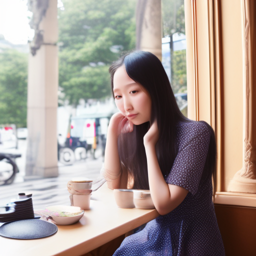

In [ ]:
result.images[0].resize((256,256))

### 4. 用指定 random seed 生圖

所有的生成模型, 在輸入時會以亂數取得輸入的特徵向量 (或更一般的 tensors)。而電腦的亂數其實是模擬出來, 也就是算出來的, 重點就是亂數種子 random seed, 也就是要指定一個數字。通常亂數種子是由系統時間來的, 每次不同所以會有些變化。但如同其他機器學習的方式一樣, 我們也可以用選定的 random seed, 來做比較好的調校控制。

In [ ]:
from PIL import Image

In [ ]:
def combine_imgs(images):
    width, height = images[0].size
    new_img = Image.new('RGB', (width, height))

    w = int(width/2)
    h = int(height/2)

    new_img.paste(images[0].resize((w,h)), (0, 0))
    new_img.paste(images[1].resize((w,h)), (w, 0))
    new_img.paste(images[2].resize((w,h)), (0, h))
    new_img.paste(images[3].resize((w,h)), (w, h))
    return new_img

我們可以電腦自動選 4 個亂數, 產生 4 個用不同 random seed 的 generators。不過這裡為了大家看到一致的結果, 直接指定 4 個數字。

In [ ]:
#seeds = np.random.randint(0, 1000000, 4)
#seeds = [int(i) for i in seeds]

In [ ]:
seeds = [91824, 396006, 903770, 781881]

In [ ]:
generator = [torch.Generator(device="cuda").manual_seed(i) for i in seeds]

In [ ]:
images = pipe(prompt, generator=generator, num_images_per_prompt=4).images

  0%|          | 0/50 [00:00<?, ?it/s]

我們看看 4 個不同 random seed 生出的結果。

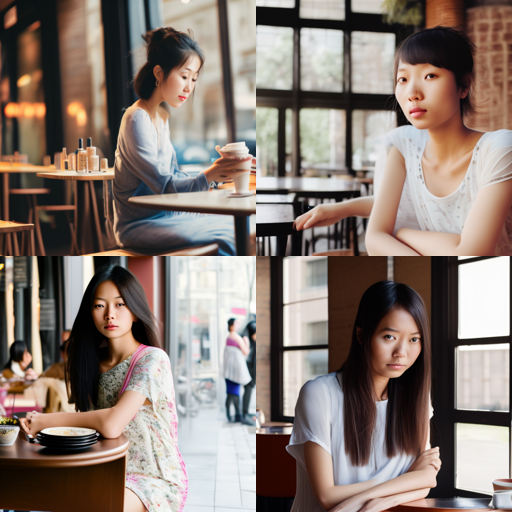

In [ ]:
combine_imgs(images)

我們可以試一下, 如果同一個 random seed, 那麼出來的結果會是一樣的! 比如選擇第 0 個 random seed。

In [ ]:
generator = torch.Generator(device="cuda").manual_seed(seeds[0])

In [ ]:
images = pipe(prompt, generator=generator).images

  0%|          | 0/50 [00:00<?, ?it/s]

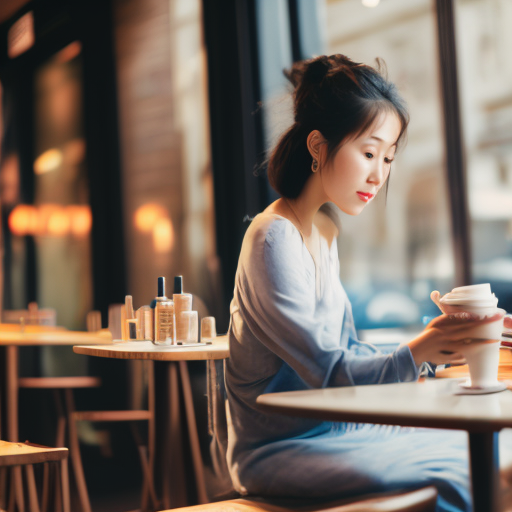

In [ ]:
images[0]

有時我們會想, 某些 prompt 要修改一下, 但又擔心這麼做原本可能還有點滿意只有點小缺點的圖會不見。現在知道控制好 random seed, 完全可以原圖重現! 因此可以大擔去調整。

### 5. 使用同樣的 random seed 生 4 張圖。

你覺得這張比較好的話 (???) 也可以用這個 random seed 生四張照片。

In [ ]:
generator = torch.Generator(device="cuda").manual_seed(seeds[0])

In [ ]:
images = pipe(prompt, generator=generator, num_images_per_prompt=4).images

  0%|          | 0/50 [00:00<?, ?it/s]

來看看 4 張圖是什麼樣子。這裡可以發現, 即使開始是同樣的 random seed, 執行 4 次還是會有 4 張不同結果。

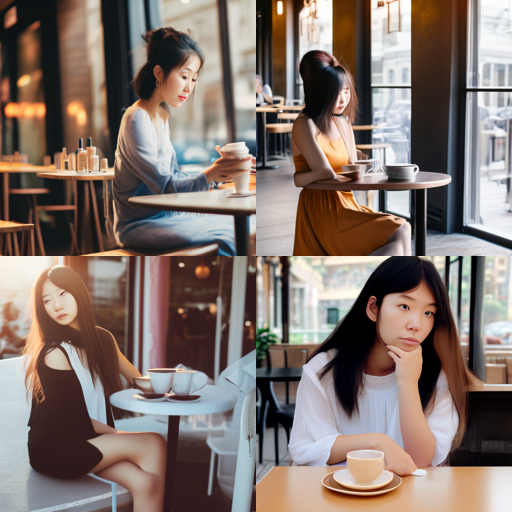

In [ ]:
combine_imgs(images)

### 6. 不喜歡的部份用 negative prompt

Stable Diffusion 進階技巧的重點就是 negative prompt。我們這裡用一些常見照片出現的缺點: 人物臉太可怕、變型、多出手或腳、長頸人等等, 告訴模型避免這些。有時模型沒有那麼聽話, 不過通常還是有相當的效果。

In [ ]:
negative_prompt = "ugly, deformed, disfigured, blurry, underage, painting, bad anatomy, long neck, extra arm, extra finger"

我們再來用指定的 random seed, prompt 之外, 再加上 negative prompt。

In [ ]:
generator = torch.Generator(device="cuda").manual_seed(seeds[0])

In [ ]:
images = pipe(prompt, negative_prompt=negative_prompt, generator=generator, num_images_per_prompt=4).images

  0%|          | 0/50 [00:00<?, ?it/s]

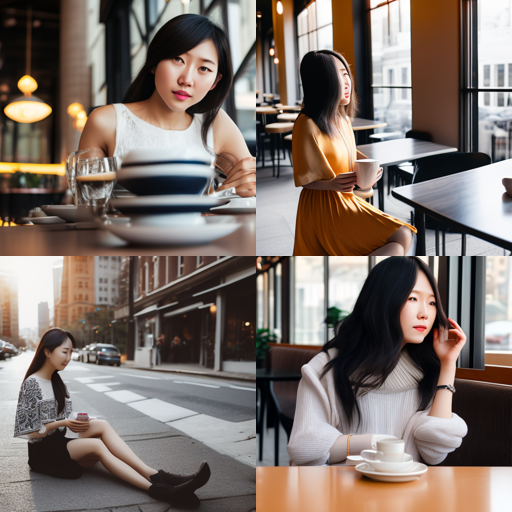

In [ ]:
combine_imgs(images)

你會發現加了 negative prompt 之後, 即使是用同樣的 random seed, 還是有相當不同的結果。不過這是因為我們最初沒有動用 negative prompt, 一開始就用，稍稍改變 prompt (或 negative prompt) 會是比較接近的圖。

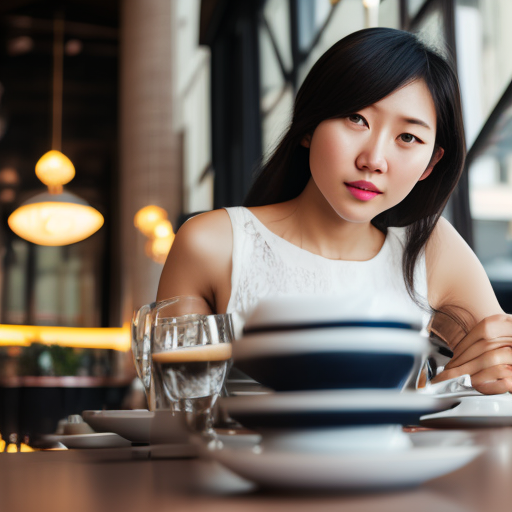

In [ ]:
images[0]